Investigating of the relation between translationese and quality on morpho-syntactic features
Jul22, 2019
Data: 

(1) 437 EN>RU student RusLTC translations to 98 newspaper informational and argumentative texts hand-labeled for quality by translation experts in the real-life contest, exam or routine class-work settings, limited to the extreme classes of the highest-scoring and lowest-scoring translations to the same source text.

(2) a collection of professional translations published by established electronic mass media 

(3) a register-comparable user defined subcorpus of the RNC to represent non-translation in the target language (reference corpus)

The texts are represented with the 45 morphosyntactic features, inspired by variational linguistics and corpus-based translation studies. The feature extraction is based on Universal Dependencies annotation. 

Step1: show that the features are useful for translationese detection
Step2: get results on their applicability for learning HTQ classes (good/bad)

In [31]:
import sys
import pandas as pd

import numpy as np
from numpy import dot
from numpy.linalg import norm
from numpy import median
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial import distance
import scipy.stats as sc

## to avoid reloading kernel after changes to imported modules
import importlib
import HTQ_functions as mm
importlib.reload(mm)

import functions as mm1
importlib.reload(mm1)

# import the functions from the helper scripts
from HTQ_functions import HTQ_get_xy, crossvalidate, quantify_diffs, recursive_elimination,cohen_d

from HTQ_functions import HTQ_pca_transform, HTQ_visualizePCA, nese_visualizePCA, HTQ_textsdensity

%matplotlib inline

In [2]:
## HTQ-labeled data: all graded targets available for newspaper register by Jul22, 2019 and the same limited to shared sources only (40 sources)
# df = pd.read_csv('/home/masha/02targets_wlv/HiT-IT/htq_40sets_45new_features_Jul21.tsv', delimiter="\t")
# df = pd.read_csv('/home/masha/02targets_wlv/HiT-IT/45feats_437targets98sources.tsv', delimiter="\t")
df = pd.read_csv('/home/masha/accuracy/543good-bad_105ST.tsv', delimiter="\t")
print(df.shape)
# ## add 'akorp' column for consistency
df.insert(loc=3,column='akorp',value='rltc')

todrop = df[df.alang == 'en'].index
df0 = df.drop(todrop)
print(len(df0))
print('Best:', len(df0.loc[df0.astatus == 'good'])) 
print('Worst:', len(df0.loc[df0.astatus == 'bad']))

(647, 48)
542
Best: 329
Worst: 213


In [3]:
## translationese data: ref-pro
df_2targets = pd.read_csv('/home/masha/02targets_wlv/45new_features_Jul21_rncM375.tsv', delimiter="\t")

ref_pro = df_2targets.loc[(df_2targets['alang'] == 'ru') & ((df_2targets['astatus'] == 'ref') | (df_2targets['astatus'] == 'pro'))]
print(ref_pro.shape)
print('Non-translations(ref):', len(ref_pro.loc[(ref_pro.alang == 'ru') & (ref_pro.astatus == 'ref')])) 
print('Pro translations:', len(ref_pro.loc[(ref_pro.alang == 'ru') & (ref_pro.astatus == 'pro')]))

(760, 49)
Non-translations(ref): 375
Pro translations: 385


************
STEP1. 
**********
Translationese (including shining thru as its special case) captures by the features visualized by PCA
**********

How good our features are for translationese detection: do they learn the difference between comparable ref and pro?

Get a picture and the general idea from PCA, validate and quantidy with cross-validated SVM classifier

Is the full feature set necessary to return a reasonable result? Can we reduce the feature set to the 15-20 most informative for the translationese classification without sacrificing the perfomance?
***********

set of Y values: {'ref', 'pro'}
Data (X for SVM) after feature selection: (760, 45)
                  Dim1      Dim2
nnargs        0.248318 -0.049261
deverbals     0.228582 -0.114595
attrib        0.219698 -0.217530
nsubj:pass    0.215007 -0.067488
longpassives  0.214789 -0.128085
lexdens       0.200573  0.026537
simple        0.176437  0.253696
aux:pass      0.175083 -0.014917
pverbals      0.169770 -0.156871
mhd           0.097978 -0.333208
bypassives    0.082361 -0.051980
cconj         0.080544 -0.219648
sentlength    0.071833 -0.352728
acl           0.071725 -0.204308
pasttense     0.044474 -0.069527
0.36715072509843416
Variance explained:  [0.223179   0.14397172]
PCA reduction of 45-feature space on EN-RU pair (variance explained by D1+D2 = 36% )


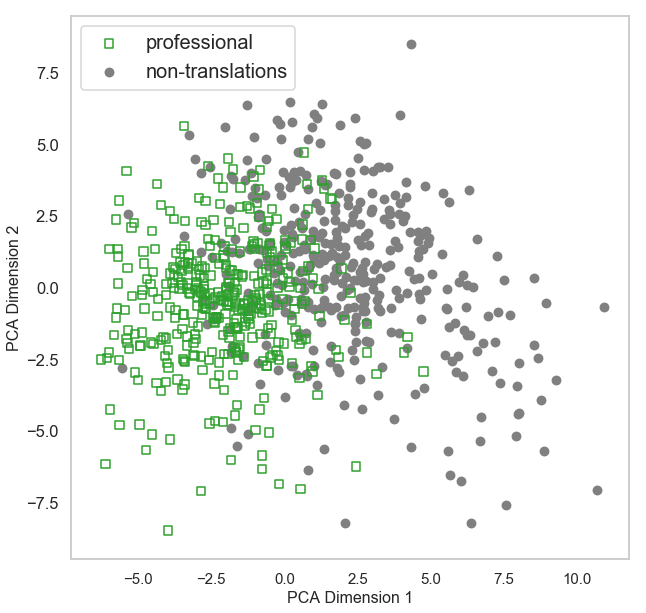

In [25]:
## your X and Y for the selected number of best features and the new df adjusted to the new number of column 
Xpro45, Ypro, _ = HTQ_get_xy(ref_pro, class_col='astatus', features=None, scaling=1, select_mode='RFE')
Xpro45pca, totvar_pro45pca, feats_pro45pca = HTQ_pca_transform(Xpro45, ref_pro, 2, 'Dim1', print_best=15)
nese_visualizePCA(Xpro45pca, Ypro, totvar_pro45pca, dimx=1, dimy=2, feats=45)

In [5]:
## ref/pro on 45 features
crossvalidate(Xpro45,Ypro, algo='SVM', grid=0, cv=10, class_weight = 'balanced') ## try RF with grid search :-)
print('=========Compare to a dummy classifier baseline=========')
crossvalidate(Xpro45,Ypro, algo='dummy', grid=0, cv=10, class_weight = 'balanced')
## longer and 4% worse than SVM
# crossvalidate(Xpro45,Ypro, algo='RF', grid=1, cv=10, class_weight = 'balanced') 

F1 over 10folds:  0.9220434754474442
Accuracy over 10folds:  0.9222337662337662
Raw confusion matrix:
 [[362  23]
 [ 36 339]]
              precision    recall  f1-score   support

         pro       0.91      0.94      0.92       385
         ref       0.94      0.90      0.92       375

   micro avg       0.92      0.92      0.92       760
   macro avg       0.92      0.92      0.92       760
weighted avg       0.92      0.92      0.92       760

Average F1 on the minority class (ref/375.0): 0.9199457259158752
=========Compare to a dummy classifier baseline=========
F1 over 10folds:  0.4798471816509792
Accuracy over 10folds:  0.4804329004329004
Raw confusion matrix:
 [[195 190]
 [205 170]]
              precision    recall  f1-score   support

         pro       0.49      0.51      0.50       385
         ref       0.47      0.45      0.46       375

   micro avg       0.48      0.48      0.48       760
   macro avg       0.48      0.48      0.48       760
weighted avg       0.48    

In [6]:
## How good are the 15 top feats for the same translationese classification?
## the function below makes AVOVA/RFE -based feature selection internaly; Ypro is not affected
Xpro15, _ , ref_pro15 = HTQ_get_xy(ref_pro, class_col='astatus', features=15, scaling=1, select_mode='RFE')
crossvalidate(Xpro15,Ypro, algo='SVM', grid=0, cv=10, class_weight = 'balanced')
print('Classification on top 15 from ANOVA F-value ranked features is just 3% inferior to the full feature set', file=sys.stderr)
print('The difference in the model performance on top features selected by ANOVA and by RFE is 0.4%, less than half of a per cent!', file=sys.stderr)
ANOVA_15 = ['sconj', 'lexdens', 'nnargs', 'simple', 'ccomp', 'possdet', 'numcls', 'relativ', 'correl', 'deverbals', 'comp', 'whconj', 'but', 'demdets', 'advers']
RFE_15 = ['possdet', 'whconj', 'relativ', 'correl', 'lexdens', 'lexTTR', 'finites', 'deverbals', 'sconj', 'but', 'comp', 'numcls', 'simple', 'nnargs', 'ccomp']
print('Intersection of the two tops: ', set(ANOVA_15) & set(RFE_15), file=sys.stderr)

set of Y values: {'ref', 'pro'}
{'ref', 'pro'}
{0, 1}
Data (X for SVM) after feature selection: (760, 15)


We use 15 best features (ranked by their importance by RFE): ['possdet', 'whconj', 'relativ', 'correl', 'lexdens', 'lexTTR', 'finites', 'deverbals', 'sconj', 'but', 'comp', 'numcls', 'simple', 'nnargs', 'ccomp']


F1 over 10folds:  0.8837587108989029
Accuracy over 10folds:  0.883982683982684
Raw confusion matrix:
 [[342  43]
 [ 45 330]]
              precision    recall  f1-score   support

         pro       0.88      0.89      0.89       385
         ref       0.88      0.88      0.88       375

   micro avg       0.88      0.88      0.88       760
   macro avg       0.88      0.88      0.88       760
weighted avg       0.88      0.88      0.88       760

Average F1 on the minority class (ref/375.0): 0.8823529411764706


Classification on top 15 from ANOVA F-value ranked features is just 3% inferior to the full feature set
The difference in the model performance on top features selected by ANOVA and by RFE is 0.4%, less than half of a per cent!
Intersection of the two tops:  {'nnargs', 'correl', 'numcls', 'lexdens', 'ccomp', 'sconj', 'but', 'whconj', 'possdet', 'relativ', 'deverbals', 'comp', 'simple'}


In [7]:
### test whether the translationese effect is detectable in student translations treating them as one class or (below) respecting the annotated quality classes
## build a joint df with ref as the third class
ref = df_2targets.loc[(df_2targets['alang'] == 'ru') & (df_2targets['astatus'] == 'ref')]

ref_qua = pd.concat([ref,df0], axis=0, join='outer', sort=False)
print(ref_qua.shape)

# ## create transl class variable to treat good/bad as one class
ref_qua0 = ref_qua.copy()
ref_qua0.loc[(ref_qua0.astatus == 'good') | (ref_qua0.astatus == 'bad'), 'astatus'] = 'transl'

(917, 49)


set of Y values: {'ref', 'transl'}
Data (X for SVM) after feature selection: (917, 45)
                  Dim1      Dim2
nnargs        0.238327  0.104100
lexdens       0.229975  0.049417
simple        0.220119 -0.207799
deverbals     0.209266  0.188444
longpassives  0.165586  0.214787
nsubj:pass    0.159943  0.158165
attrib        0.142393  0.305202
aux:pass      0.127210  0.079614
pverbals      0.118837  0.192731
bypassives    0.034308  0.055335
sup           0.014088  0.019231
cconj         0.011018  0.247143
addit        -0.002005  0.176629
mhd          -0.033535  0.347799
pasttense    -0.038853  0.073577
0.3065736438079003
Variance explained:  [0.16434498 0.14222867]
PCA reduction of 45-feature space on EN-RU pair (variance explained by D1+D2 = 30% )


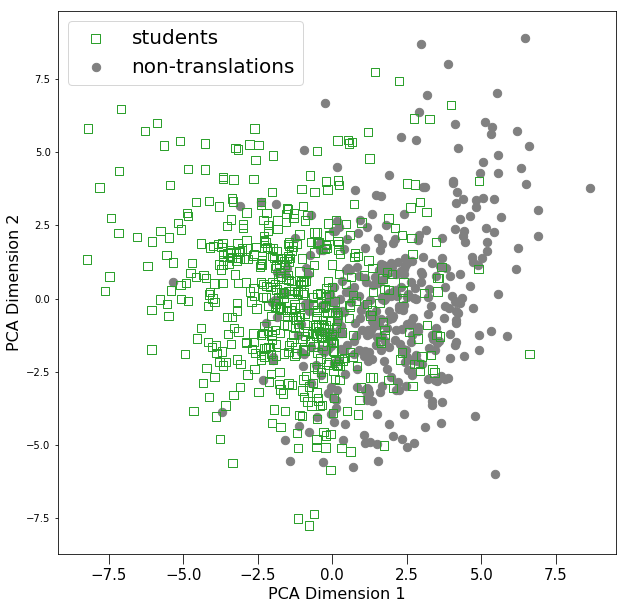

F1 over 10folds:  0.9629401561649527
Accuracy over 10folds:  0.9640684000431546
Raw confusion matrix:
 [[361  14]
 [ 19 523]]
              precision    recall  f1-score   support

         ref       0.95      0.96      0.96       375
      transl       0.97      0.96      0.97       542

   micro avg       0.96      0.96      0.96       917
   macro avg       0.96      0.96      0.96       917
weighted avg       0.96      0.96      0.96       917

Average F1 on the minority class (ref/375.0): 0.9562913907284769


Translationese is as clearly revealed in student translations, in fact, the SVM results are 2% better


In [8]:
Xq,Yq, _ = HTQ_get_xy(ref_qua0, class_col='astatus', features=None, scaling=1, select_mode='RFE')
Xq45pca, totvar_q45, feats_q45 = HTQ_pca_transform(Xq, ref_qua0, 2, 'Dim1', print_best=15)
nese_visualizePCA(Xq45pca, Yq, totvar_q45, dimx=1, dimy=2, feats=45)
crossvalidate(Xq,Yq, algo='SVM', grid=0, cv=10, class_weight = 'balanced')
print('Translationese is as clearly revealed in student translations, in fact, the SVM results are 2% better', file=sys.stderr)

In [9]:
## the function below makes AVOVA/RFE -based feature selection internaly
Xq15,Yq, _ = HTQ_get_xy(ref_qua0, class_col='astatus', features=15, scaling=1, select_mode='RFE')
crossvalidate(Xq15,Yq, algo='SVM', grid=0, cv=10, class_weight = 'balanced')

set of Y values: {'ref', 'transl'}
{'ref', 'transl'}
{0, 1}
Data (X for SVM) after feature selection: (917, 15)


We use 15 best features (ranked by their importance by RFE): ['possdet', 'whconj', 'relativ', 'pied', 'correl', 'lexdens', 'finites', 'sconj', 'advers', 'comp', 'sup', 'demdets', 'acl', 'ccomp', 'xcomp']


F1 over 10folds:  0.9273396664524247
Accuracy over 10folds:  0.9292357011852103
Raw confusion matrix:
 [[351  24]
 [ 41 501]]
              precision    recall  f1-score   support

         ref       0.90      0.94      0.92       375
      transl       0.95      0.92      0.94       542

   micro avg       0.93      0.93      0.93       917
   macro avg       0.92      0.93      0.93       917
weighted avg       0.93      0.93      0.93       917

Average F1 on the minority class (ref/375.0): 0.9152542372881355


In [10]:
print('Reducing the feature set to the top 15 best translationese indicators does not degrade the results much', file=sys.stderr)
pro_15_RFE = ['possdet', 'whconj', 'relativ', 'correl', 'lexdens', 'lexTTR', 'finites', 'deverbals', 'sconj', 'but', 'comp', 'numcls', 'simple', 'nnargs', 'ccomp']
stu_15_RFE = ['possdet', 'whconj', 'relativ', 'pied', 'correl', 'lexdens', 'longpassives', 'sconj', 'advers', 'but', 'comp', 'sup', 'nnargs', 'ccomp', 'parataxis']
print('Intersection of the best translationese indicators in pro and stu:', set(pro_15_RFE) & set(stu_15_RFE), file=sys.stderr)

Reducing the feature set to the top 15 best translationese indicators does not degrade the results much
Intersection of the best translationese indicators in pro and stu: {'nnargs', 'correl', 'lexdens', 'ccomp', 'sconj', 'but', 'whconj', 'possdet', 'relativ', 'comp'}


set of Y values: {'ref', 'bad', 'good'}
Data (X for SVM) after feature selection: (917, 45)
0.3065736438071852
Variance explained:  [0.16434498 0.14222867]
PCA reduction of 45-feature space (best-worst, variance explained by D1+D2 = 30% )


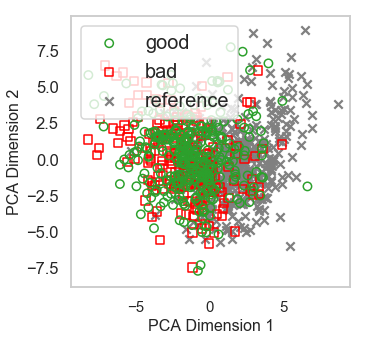

In [26]:
## Can PCA visualize distinctions between good and bad in the presence of non-translated Russian
Xq3,Yq3, _ = HTQ_get_xy(ref_qua, class_col='astatus', features=None, scaling=1, select_mode='RFE')
Xq3_45pca, totvar3_q45, feats3_q45 = HTQ_pca_transform(Xq3, ref_qua, 2, 'Dim1', print_best=0)
HTQ_visualizePCA(Xq3_45pca, Yq3, totvar3_q45, dimx=1, dimy=2, feats=45)

# ## catch out the outlier in the new data
### DONE EN_1_199 deleted ###
# ref_qua0 = ref_qua.copy()
# ref_qua0.insert(loc=4, column='pca1',value=Xq3_45pca[:,0])
# outlier = ref_qua0.loc[ref_qua0.pca1 > 8,'afile']
# print(outlier)

ADDITIONAL:: ANOVA (used for feature selection) assumes normal distribution of values: lets have a quick look whether it is the case for our dataset

It looks like five features are less normally distributed than others (ccomp, but, possdet, comp, correl), NOT SHOWN BELOW

***********
Finally, explore the nature of the translationese effects that our features pick: position good and bad in the space as ref and sources!
***********

(1022, 49)
set of Y values: {'ref', 'bad', 'good', 'source'}
Data (X for SVM) after feature selection: (1022, 45)
0.2911890693140017
Variance explained:  [0.15571165 0.13547742]
PCA reduction of 45-feature space (best-worst, variance explained by D1+D2 = 29% )


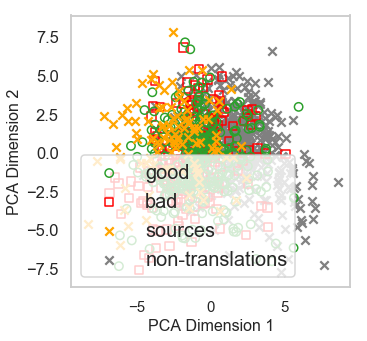

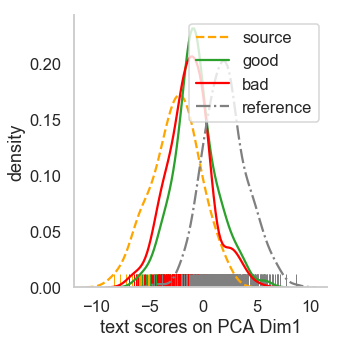

In [27]:
## comparing en, ru_ref, bad, good
ref_qua_en = pd.concat([ref,df], axis=0, join='outer', sort=False)
print(ref_qua_en.shape)
X4,Y4, df4 = HTQ_get_xy(ref_qua_en, class_col='astatus', features=None, scaling=1, select_mode='RFE')
X4pca, totvar_4, feats_4 = HTQ_pca_transform(X4, df4, 2, 'Dim1', print_best=0)
HTQ_visualizePCA(X4pca, Y4, totvar_4, dimx=1, dimy=2, feats=45)
HTQ_textsdensity(X4pca[:,0], Y4, dimx=1, feats=45)

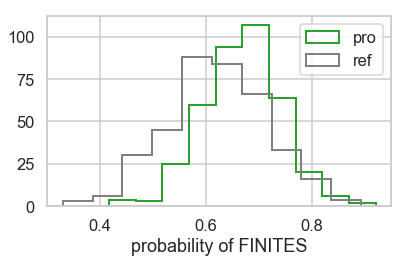

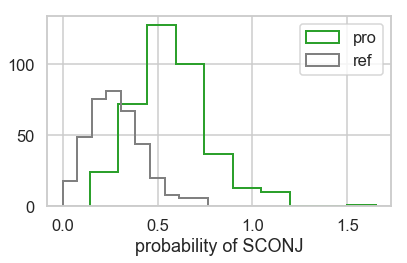

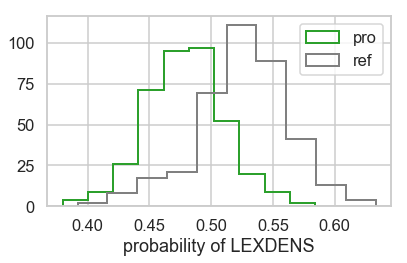

In [13]:
# slices a DataFrame and prints three hists to one axes
pro = ref_pro[ref_pro['astatus']=='pro']
ref = ref_pro[ref_pro['astatus']=='ref']

anova_top3pro = ['finites', 'sconj', 'lexdens']
for feat in anova_top3pro:
    #print(learners[feat])
    ax = sns.distplot(pro[feat], kde=False, bins=10, rug=False, hist_kws={"color": "C2","histtype": "step", "linewidth": 2, "alpha": 1, "label":"pro"})
    ax = sns.distplot(ref[feat], kde=False, bins=10, rug=False, hist_kws={"color": "grey","histtype": "step", "linewidth": 2,  "alpha": 1,"label":"ref"})
    

    ax.set(xlabel="probability of %s" %(feat.upper()), ylabel='')
    plt.legend()
    plt.tight_layout()
    plt.show()

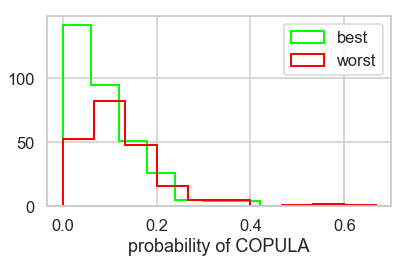

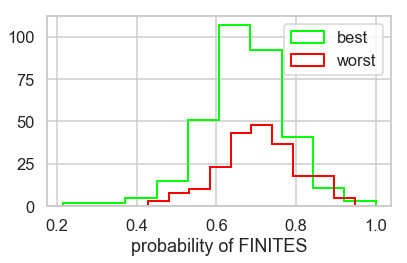

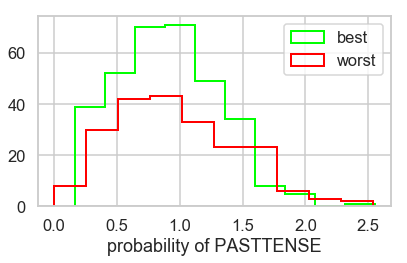

In [14]:
good = df0[df0['astatus']=='good']
bad = df0[df0['astatus']=='bad']

# col_labels = df0.columns
# print(col_labels[3:])
## for good/bad dataset lets look at the top five thrown up by ANOVA for good/bad distinction (see below in Step2)
anova_top3q = ['copula', 'finites', 'pasttense']
for feat in anova_top3q:
    #print(learners[feat])
    ax = sns.distplot(good[feat], kde=False, bins=10, rug=False, hist_kws={"color": "lime","histtype": "step", "linewidth": 2, "alpha": 1, "label":"best"})
    ax = sns.distplot(bad[feat], kde=False, bins=10, rug=False, hist_kws={"color": "red","histtype": "step", "linewidth": 2,  "alpha": 1,"label":"worst"})
    

    ax.set(xlabel="probability of %s" %(feat.upper()), ylabel='')
    plt.legend()
    plt.tight_layout()
    plt.show()

***********
Step 1 of the research confirms that our feature set is relevant for translationese detection. 

We get up to 92-94% accuracy on the binary classification of translation and non-translations.

The features that capture this dictinctions most rigorously (shared by both translational corpora) include: 'relativ', 'nnargs', 'sconj', 'whconj', 'but', 'ccomp', 'lexdens', 'correl', 'possdet', 'comp'
***********

In [15]:
## if we want to quantify differences between values of a given variable in two given corpora:
quantify_diffs(ref_pro, feat='deverbals', corpus1='ref', corpus2='pro')

two-tails t-test for independent variables with unequal variance for
 DEVERBALS
	 REF PRO
Means:	 0.3364 0.1833
Variance: 0.0414 0.0075
STD:	 0.2035 0.0865

REF vs PRO
t = 13.4161  p = 2.73263e-35 df = 758
Effect size: 0.982336534624217 



**************
STEP2. 

Let's look what the 45 features are worth in terms of straightforward learning from good-bad labels

Are the same feature get into top best for best-worst as in translations-nontranslations??

===Well, here is the thing===: it is difficult to be talking about the top best features in classification based on quality because despite my extensive efforts I was unable to beat a dummy classifier baseline on our features. 

what I tried:

(1) another feature selection method (recursive feature elimination) --- it did return a set of 20 which performed as well as the full feature set of 45

(2) use a different algo (RF) with a grid search --- I gained 3% but still the result is worse than that of a dummy! Random Forests algo on the top 15 translationese indicators return F1=0.61096, which is way below 66% on a dummy classifier 

(3) plugged in another (smaller) set of translations, trying to address the class imbalance. NOPE! No Major difference, the same overall result is reproduced. 
However, class imbalance is accounted for in producing folds for cross-validation and during the evaluation of the algorithms --- on a smaller, but balanced data set, dummy is only 1% better than translationese features, while bad are 1% more accurately predicted on average (if we can speak of any accuracy at all with the best result (F1-0.681383) obtained by SVM on 20 top features (selected by RFE) which is 1% better than dummy with F1=0.6743589

Major discovery on July21: classification into good/bad on any number of features from our set is by 5% worse than a dummy classifier.
Is there any way to demonstrate that our human labeled translation quality classes are real and include linguistically different texts? just to demonstrate the sanity and integrity of the data?
**************

set of Y values: {'bad', 'good'}
Data (X for SVM) after feature selection: (542, 45)
0.24495587264702684
Variance explained:  [0.14051905 0.10443683]
PCA reduction of 45-feature space (best-worst, variance explained by D1+D2 = 24% )


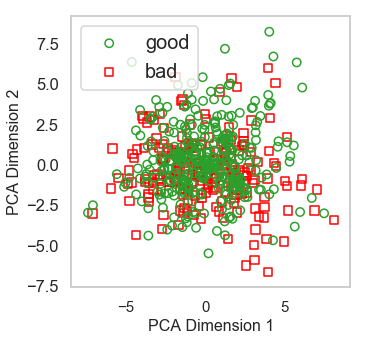

F1 over 10folds:  0.634707360299432
Accuracy over 10folds:  0.6491665078457531
Raw confusion matrix:
 [[125  88]
 [102 227]]
              precision    recall  f1-score   support

         bad       0.55      0.59      0.57       213
        good       0.72      0.69      0.70       329

   micro avg       0.65      0.65      0.65       542
   macro avg       0.64      0.64      0.64       542
weighted avg       0.65      0.65      0.65       542

Average F1 on the minority class (bad/213.0): 0.5681818181818182

====DUMMY (most_frequent)====
F1 over 10folds:  0.37773326572008115
Accuracy over 10folds:  0.6070440251572327
Raw confusion matrix:
 [[  0 213]
 [  0 329]]
              precision    recall  f1-score   support

         bad       0.00      0.00      0.00       213
        good       0.61      1.00      0.76       329

   micro avg       0.61      0.61      0.61       542
   macro avg       0.30      0.50      0.38       542
weighted avg       0.37      0.61      0.46       542

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
### run the good/bad data thru the same pipeline
Xq45_2,Yq45_2, _ = HTQ_get_xy(df0, class_col='astatus', features=None, scaling=1, select_mode='RFE')
Xq45_2pca, totvar_q45_2, feats_q45_2 = HTQ_pca_transform(Xq45_2, df0, 2, 'Dim1', print_best=0)
HTQ_visualizePCA(Xq45_2pca, Yq45_2, totvar_q45_2, dimx=1, dimy=2, feats=45)
crossvalidate(Xq45_2,Yq45_2, algo='SVM', grid=0, cv=10, class_weight='balanced')
crossvalidate(Xq45_2,Yq45_2, algo='dummy', grid=0, cv=10, class_weight='balanced')

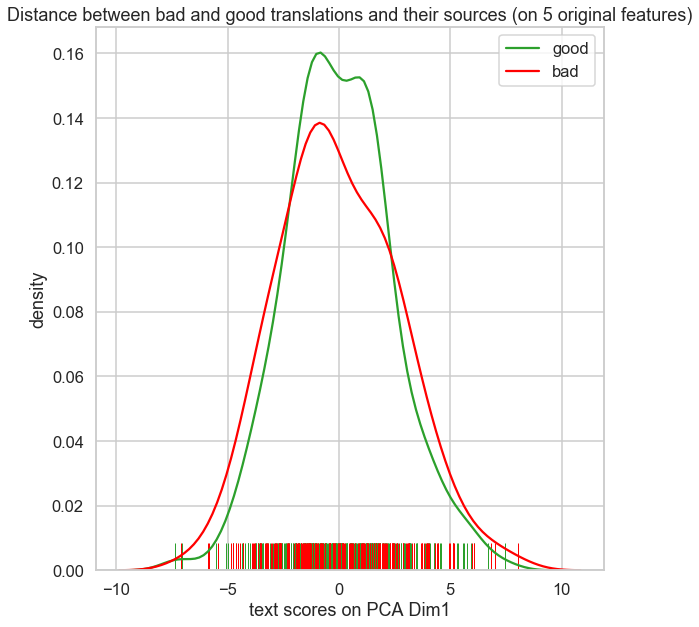

In [17]:
HTQ_textsdensity(Xq45_2pca[:,0], Yq45_2, dimx=1, feats=5)

In [30]:
Xq15_2,Yq15_2, _ = HTQ_get_xy(df0, class_col='astatus', features=15, scaling=1, select_mode='RFE')
crossvalidate(Xq15_2,Yq15_2, algo='SVM', grid=0, cv=10, class_weight='balanced')
crossvalidate(Xq15_2,Yq15_2, algo='dummy', grid=0, cv=10, class_weight='balanced')
print('lets look at 15 best quality predictors', file=sys.stderr)

set of Y values: {'bad', 'good'}
{'bad', 'good'}
{0, 1}
Data (X for SVM) after feature selection: (542, 15)


We use 15 best features (ranked by their importance by RFE): ['copula', 'attrib', 'pasttense', 'lexdens', 'lexTTR', 'mpred', 'finites', 'infs', 'deverbals', 'addit', 'comp', 'acl', 'ccomp', 'nsubj:pass', 'parataxis']


F1 over 10folds:  0.6357777646535845
Accuracy over 10folds:  0.6474830061622515
Raw confusion matrix:
 [[136  77]
 [114 215]]
              precision    recall  f1-score   support

         bad       0.54      0.64      0.59       213
        good       0.74      0.65      0.69       329

   micro avg       0.65      0.65      0.65       542
   macro avg       0.64      0.65      0.64       542
weighted avg       0.66      0.65      0.65       542

Average F1 on the minority class (bad/213.0): 0.5874730021598273

====DUMMY====
F1 over 10folds:  0.4863718334635806
Accuracy over 10folds:  0.5221231179721745
Raw confusion matrix:
 [[ 70 143]
 [116 213]]
              precision    recall  f1-score   support

         bad       0.38      0.33      0.35       213
        good       0.60      0.65      0.62       329

   micro avg       0.52      0.52      0.52       542
   macro avg       0.49      0.49      0.49       542
weighted avg       0.51      0.52      0.52       542

Average F1 on 

lets look at 15 best quality predictors


set of Y values: {'bad', 'good'}
{'bad', 'good'}
{0, 1}
Data (X for SVM) after feature selection: (542, 5)
0.5461980676825864
Variance explained:  [0.31867377 0.2275243 ]


We use 5 best features (ranked by their importance by RFE): ['copula', 'pasttense', 'lexdens', 'lexTTR', 'ccomp']


F1 over 10folds:  0.6533205027656364
Accuracy over 10folds:  0.6605831903945111
Raw confusion matrix:
 [[142  71]
 [113 216]]
              precision    recall  f1-score   support

         bad       0.56      0.67      0.61       213
        good       0.75      0.66      0.70       329

   micro avg       0.66      0.66      0.66       542
   macro avg       0.65      0.66      0.65       542
weighted avg       0.68      0.66      0.66       542

Average F1 on the minority class (bad/213.0): 0.6068376068376068


It looks like quality is not about translationese
PCA on 5 features yields visually more impressive results


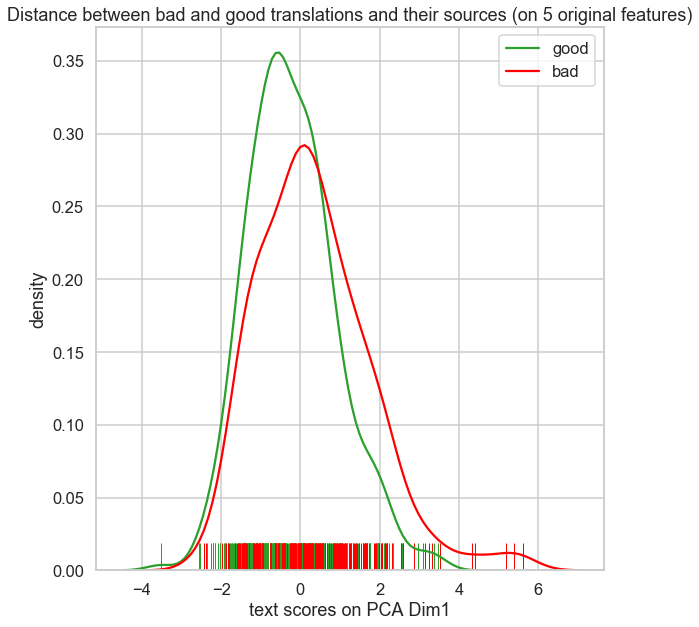

In [19]:
Xq5_2,Y_2, df0_5 = HTQ_get_xy(df0, class_col='astatus', features=5, scaling=1, select_mode='RFE')
Xq5_2pca, totvar_q5_2, feats_q5_2 = HTQ_pca_transform(Xq5_2, df0_5, 2, 'Dim1', print_best=0)
HTQ_textsdensity(Xq5_2pca[:,0], Y_2, dimx=1, feats=5)
crossvalidate(Xq5_2,Y_2, algo='SVM', grid=0, cv=10, class_weight = 'balanced')
print('It looks like quality is not about translationese', file=sys.stderr)
print('PCA on 5 features yields visually more impressive results', file=sys.stderr)

no ML setting produced results anywhere near the dummy below

exactly how bad the results above are? compare to the results of a ==DUMMY== classifier, which assigns labels with respect to the data distribution

In [20]:
print('=== I am not sure that we can talk about any positive results here or features correlated with quality as a dummy classifier returns 5% higher results than our features! But the description of best TQ features below ignores this consideration ===', file=sys.stderr)


=== I am not sure that we can talk about any positive results here or features correlated with quality as a dummy classifier returns 5% higher results than our features! But the description of best TQ features below ignores this consideration ===


PCA maximizes the variance between the components of vectors presented and find sets of components (=features) that account for the most variance in the data. Hence, it makes sense to offer it a less heterogenious dataset (not 

In [21]:
## and finally, just to exaust all ideas -- I am running the most effective classifier, equipped with grid search on the top 15 translationese features:
stu_15_RFE = ['possdet', 'whconj', 'relativ', 'pied', 'correl', 'lexdens', 'longpassives', 'sconj', 'advers', 'but', 'comp', 'sup', 'nnargs', 'ccomp', 'parataxis']
select_cols = df0.loc[:,stu_15_RFE]
X = select_cols.values
crossvalidate(X,Y_2, algo='SVM', grid=0, cv=10, class_weight = 'balanced')

F1 over 10folds:  0.5550333846939244
Accuracy over 10folds:  0.5720233784384728
Raw confusion matrix:
 [[107 106]
 [126 203]]
              precision    recall  f1-score   support

         bad       0.46      0.50      0.48       213
        good       0.66      0.62      0.64       329

   micro avg       0.57      0.57      0.57       542
   macro avg       0.56      0.56      0.56       542
weighted avg       0.58      0.57      0.57       542

Average F1 on the minority class (bad/213.0): 0.4798206278026906
